# Лекция 9: Разреженная линейная алгебра

## Краткий обзор предыдущей лекции
- Рандомизированное умножение матриц
- Оценка следа по методу Хатчинсона
- Рандомизированное SVD
- Метод Качмажа

## План сегодняшней лекции

- Простая тема в параллельных вычислениях в линейной алгебре (на примере умножения матрицы на вектор)
- Часть о разреженных матрицах (с отдельным планом)

## Матрицы большого размера

- Если размер плотной матрицы огромен, то она не может быть сохранена в памяти
- Возможные варианты
    - Эта матрица **структурированная**, например, блочная теплицева с теплицевыми блоками (следующие лекции). Тогда возможно сжатое хранение
    - Для неструктурированных плотных матриц помогает **распределенная память**
    - MPI для обработки матриц с распределенным хранением

### Распределенная память и MPI

- Разделение матрицы на блоки и хранение их на разных машинах
- Каждая машина имеет свое собственное адресное пространство и не может повредить данные на других машинах
- В этом случае машины взаимодействуют друг с другом для объединения результатов вычислений
- [MPI (Message Passing Interface)](https://en.wikipedia.org/wiki/Message_Passing_Interface) - это стандарт для параллельных вычислений в распределенной памяти


### Пример: умножение матрицы на вектор

- Предположим, что вы хотите вычислить $Ax$, и матрица $A$ не может быть сохранена в доступной памяти
- Тогда вы можете разделить её на блоки и распределить блоки на отдельные машины
- Возможные стратегии
    - 1D блочное разделение разбивает только строки на блоки
    - 2D блочное разделение разбивает как строки, так и столбцы

#### 1D blocking scheme
<img src="1d_block.jpg">

#### Total time of computing matvec with 1D blocking

- Each machine has $n / p $ complete rows and $n / p$ elements of vector
- Total operations are $n^2 / p$
- Total time for sending and writing data are $t_s \log p + t_w n$, where $t_s$ time unit for sending and $t_w$ time unit for writing

#### 2D blocking scheme

<img src="2d_block.png" width=400>

#### Общее время вычисления умножения матрицы на вектор с 2D блочным разделением

- Каждая машина имеет блок размера $n / \sqrt{p}$ и $n / \sqrt{p}$ элементов вектора
- Общее количество операций составляет $n^2 / p$
- Общее время для отправки и записи данных приблизительно равно $t_s \log p + t_w (n/\sqrt{p}) \log p$, где $t_s$ - единица времени для отправки, а $t_w$ - единица времени для записи

### Пакеты, поддерживающие распределенное хранение

- [ScaLAPACK](http://www.netlib.org/scalapack/)
- [Trilinos](https://trilinos.org/)

В Python вы можете использовать [mpi4py](https://mpi4py.readthedocs.io/en/stable/) для параллельного программирования вашего алгоритма.

- PyTorch поддерживает распределенное обучение и хранение данных, подробности [здесь](https://pytorch.org/tutorials/intermediate/dist_tuto.html)

### Резюме по обработке больших неструктурированных матриц

- Распределенный способ хранения
- MPI
- Пакеты, использующие параллельные вычисления
- Различные стратегии блочного разделения

## Введение в разреженные матрицы

- Для задач плотной линейной алгебры мы ограничены памятью для хранения полной матрицы, это $N^2$ параметров.

- Класс **разреженных** матриц, где большинство элементов равны нулю, позволяет нам **как минимум** хранить такие матрицы.

Вопрос в том, можем ли мы:

- решать линейные системы
- решать задачи на собственные значения

с разреженными матрицами

## План следующей части лекции

Теперь мы поговорим о **разреженных матрицах**, где они возникают, как мы их храним, как мы с ними работаем.


- Форматы: список списков и формат сжатых разреженных строк, связь с графами
- Умножение матрицы на вектор
- Параллельная обработка разреженных матриц
- Быстрые прямые решатели для метода Гаусса (начало)

## Применения разреженных матриц

Разреженные матрицы возникают в:

- дифференциальных уравнениях в частных производных (ДУЧП), математическом моделировании
- анализе графов, например, при анализе социальных сетей
- рекомендательных системах
- везде, где отношения между объектами являются "разреженными".

### Разреженные матрицы повсеместны в ДУЧП

Простейшее дифференциальное уравнение в частных производных (ДУЧП), называемое 

**Уравнение Лапласа**:  

$$
   \Delta T = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = f(x,y), \quad x,y\in \Omega\equiv[0,1]^2,
$$

$$
    T_{\partial\Omega} = 0.
$$

#### Discretization

$$\frac{\partial^2 T}{\partial x^2} \approx \frac{T(x+h) + T(x-h) - 2T(x)}{h^2} + \mathcal{O}(h^2),$$

same for $\frac{\partial^2 T}{\partial y^2},$
and we get a linear system.  
    First, let us consider **one-dimensional case**:

После дискретизации одномерного уравнения Лапласа с граничными условиями Дирихле мы получаем

$$\frac{u_{i+1} + u_{i-1} - 2u_i}{h^2} = f_i,\quad i=1,\dots,N-1$$

$$ u_{0} = u_N = 0$$
или в матричной форме

$$ A u = f,$$
и (для $n = 5$)
$$A=-\frac{1}{h^2}\begin{bmatrix} 2 & -1 & 0 & 0 & 0\\ -1 & 2 & -1 & 0 &0 \\ 0 & -1 & 2& -1 & 0 \\ 0 & 0 & -1 & 2  &-1\\ 0 & 0 & 0 & -1 & 2 \end{bmatrix}$$

Матрица является **трехдиагональной** и **разреженной**  
(а также **теплицевой**: все элементы на диагонали одинаковы)

#### Блочная структура в 2D
В двух измерениях мы получаем уравнение вида

$$-\frac{4u_{ij} -u_{(i-1)j} - u_{(i+1)j} - u_{i(j-1)}-u_{i(j+1)}}{h^2} = f_{ij},$$

или в форме **кронекерова произведения**  

$$\Delta_{2D} = \Delta_{1D} \otimes I + I \otimes \Delta_{1D},$$

где $\Delta_{1D}$ - одномерный оператор Лапласа, а $\otimes$ - **кронекерово произведение** матриц.

Для матриц $A\in\mathbb{R}^{n\times m}$ и $B\in\mathbb{R}^{l\times k}$ их кронекерово произведение определяется как блочная матрица вида

$$
   A\otimes B = \begin{bmatrix}a_{11}B & \dots & a_{1m}B \\ \vdots & \ddots & \vdots \\ a_{n1}B & \dots & a_{nm}B\end{bmatrix}\in\mathbb{R}^{nl\times mk}.
$$

В блочной матричной форме 2D-матрица Лапласа может быть записана в следующем виде:  

$$A = -\frac{1}{h^2}\begin{bmatrix} \Delta_1 + 2I & -I & 0 & 0 & 0\\ -I & \Delta_1 + 2I  & -I & 0 &0 \\ 0 & -I & \Delta_1 + 2I & -I & 0 \\ 0 & 0 & -I & \Delta_1 + 2I   &-I\\ 0 & 0 & 0 & -I & \Delta_1 + 2I \end{bmatrix}$$

##### Краткий список свойств кронекерова произведения

- Оно билинейно
- $(A\otimes B) (C\otimes D) = AC \otimes BD$
- Пусть $\mathrm{vec}(X)$ - векторизация матрицы $X$ по столбцам. Тогда 
$\mathrm{vec}(AXB) = (B^T \otimes A) \mathrm{vec}(X).$

### Разреженные матрицы помогают в вычислительной теории графов

- Графы представляются матрицей смежности, которая обычно разрежена
- Численное решение задач теории графов основано на обработке этой разреженной матрицы
    - Обнаружение сообществ и кластеризация графов
    - Обучение ранжированию
    - Случайные блуждания
    - Другие
- Пример: вероятно, самый большой общедоступный граф гиперссылок состоит из 3,5 миллиардов веб-страниц и 128 миллиардов гиперссылок, подробнее см. [здесь](http://webdatacommons.org/hyperlinkgraph/)
- Графы среднего масштаба для тестирования ваших алгоритмов доступны в [Стэнфордской коллекции больших сетевых данных](https://snap.stanford.edu/data/)

### Коллекция разреженных матриц SuiteSparse (ранее известная как коллекция разреженных матриц Флориды)

Больше разреженных матриц вы можете найти в [коллекции матриц SuiteSparse](https://sparse.tamu.edu/), которая содержит различные типы матриц для разных приложений.

In [3]:
from IPython.display import IFrame
IFrame("http://yifanhu.net/GALLERY/GRAPHS/search.html", width=700, height=450)

### Sparse matrices and deep learning

- DNN has a lot of parameters
- Some of them may be redundant
- How to prune the parameters without significantly accuracy reduction?
- [Sparse variational dropout method](https://github.com/ars-ashuha/variational-dropout-sparsifies-dnn) leads to significantly sparse filters in DNN almost without accuracy decreasing: the idea of **pruning**

## Разреженная матрица: построение

- Мы можем создать разреженную матрицу, используя пакет **scipy.sparse** (на самом деле это **не лучший** пакет для разреженных матриц)

- Мы можем работать с действительно большими размерами (по крайней мере, для хранения этой матрицы в памяти)

Обратите внимание на следующие функции
- Создание разреженных матриц с заданными диагоналями ```spdiags```
- Кронекерово произведение разреженных матриц ```kron```
- Также для разреженных матриц перегружена арифметика

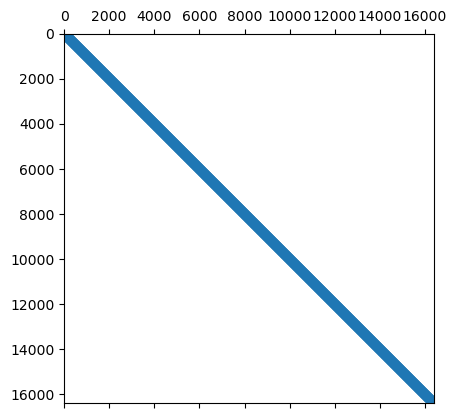

In [6]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
%matplotlib inline
n = 128
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
plt.spy(A, aspect='equal', marker='.', markersize=5)

### Структура разреженности

- Команда ```spy``` отображает структуру разреженности матрицы: пиксель $(i, j)$ отображается, если соответствующий элемент матрицы ненулевой.

- Структура разреженности действительно важна для понимания сложности алгоритмов разреженной линейной алгебры.

- Часто для анализа "насколько сложна" матрица достаточно только структуры разреженности.

### Разреженная матрица: определение

- Определение "разреженной матрицы" заключается в том, что количество **ненулевых элементов** намного меньше общего числа элементов.

- Вы можете выполнять основные операции линейной алгебры (в первую очередь решение линейных систем) быстрее, чем при работе с полной матрицей.

## Что нам нужно выяснить, чтобы понять, как это работает на самом деле

- **Вопрос 1:** Как хранить разреженную матрицу в памяти?

- **Вопрос 2:** Как быстро умножать разреженную матрицу на вектор?

- **Вопрос 3:** Как быстро решать линейные системы с разреженными матрицами?

### Хранение разреженных матриц

Существует множество форматов хранения, важные из них:

- COO (Координатный формат)
- LIL (Списки списков)
- CSR (сжатая разреженная строка)
- CSC (сжатый разреженный столбец)
- Блочные варианты

В ```scipy``` есть конструкторы для каждого из этих форматов, например 

#### Координатный формат (COO)

Простейший формат - это использование **координатного формата** для представления разреженной матрицы в виде позиций и значений ненулевых элементов.

#### Основные недостатки

- Не оптимален по хранению (почему?)
- Не оптимален для умножения матрицы на вектор (почему?)
- Не оптимален для удаления элементов, так как нужно выполнить **nnz** операций, чтобы найти один элемент (это хорошо в формате LIL)

Первые два недостатка решаются форматом **сжатой разреженной строки** (CSR).

#### Сжатая разреженная строка (CSR)

В формате CSR матрица хранится в виде 3 различных массивов:

### Разреженные матрицы в PyTorch и Tensorflow

- PyTorch поддерживает разреженные матрицы, хранящиеся в формате COO
- Неполная обратная операция для этих матриц, см. сводку [здесь](https://github.com/pytorch/pytorch/issues/9674)
- Tensorflow также поддерживает разреженные матрицы в формате COO
- Список поддерживаемых операций находится [здесь](https://www.tensorflow.org/api_docs/python/tf/sparse), и поддержка градиентов также ограничена

### CSR помогает в умножении разреженной матрицы на вектор (SpMV)

Давайте проведем короткий тест на время выполнения

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 1024
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
B = coo_matrix(A)
%timeit A.dot(rhs)
%timeit B.dot(rhs)

3.24 ms ± 74.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.7 ms ± 379 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Как видите, **CSR** работает быстрее, и для более **неструктурированных шаблонов** выигрыш будет еще больше.

### Разреженные матрицы и эффективность

- Разреженные матрицы дают снижение вычислительной сложности.
- Но они **не очень хороши** для параллельной/GPU реализации.
- Они не дают максимальной эффективности из-за **случайного доступа к данным**.
- Обычно пиковая эффективность в $10\%-15\%$ считается хорошей.

### Вспомним, как мы измеряем эффективность операций линейной алгебры

Стандартный способ измерения эффективности операций линейной алгебры на конкретной вычислительной архитектуре - использовать **flops** (количество операций с плавающей точкой в секунду)

Мы можем измерить пиковую эффективность обычного умножения матрицы на вектор.

In [4]:
import numpy as np
import time
n = 4000
k = 1400
a = np.random.randn(n, n)
v = np.random.randn(n, k)
t = time.time()
np.dot(a, v)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  ((k*2 * n ** 2)/t) / 10 ** 9))

Time:  9.0e-02, Efficiency:  5.0e+02 Gflops


In [14]:
import scipy as sp
n = 4000
k = 2000
ex = np.ones(n)
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n, k)
t = time.time()
a.dot(rhs)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  (3 * n * k) / t / 10 ** 9))

Time:  8.1e-03, Efficiency:  3.0e+00 Gflops


### Случайный доступ к данным и кэш-промахи

- Изначально все элементы матрицы и вектора хранятся в оперативной памяти (RAM)
- Если вы хотите вычислить произведение матрицы на вектор, часть элементов матрицы и вектора перемещается в **кэш** (быстрая память малого объема, см. (лекцию об алгоритме Штрассена))
- После этого процессор берет данные из кэша для обработки и возвращает результат также в кэш
- Если процессору нужны данные, которых еще нет в кэше, такая ситуация называется **кэш-промахом**
- При кэш-промахе требуемые данные перемещаются из оперативной памяти в кэш

**Вопрос**: что если в кэше нет свободного места?


- Чем больше кэш-промахов, тем медленнее вычисления

#### CSR sparse matrix by vector product

### Переупорядочение уменьшает кэш-промахи

- Если ```ja``` хранит последовательные элементы, то они будут перемещены в кэш вместе, и количество кэш-промахов уменьшается
- Это происходит, когда разреженная матрица является ленточной или по крайней мере блочно-диагональной
- Мы можем преобразовать заданную разреженную матрицу в ленточную или блочно-диагональную с помощью *перестановок*

- Пусть $P$ - матрица перестановки строк, а $Q$ - матрица перестановки столбцов
- $A_1 = PAQ$ - матрица, которая имеет меньшую ширину ленты, чем $A$
- $y = Ax \to \tilde{y} = A_1 \tilde{x}$, где $\tilde{x} = Q^{\top}x$ и $\tilde{y} = Py$
- [Разделенная блочно-диагональная форма](http://albert-jan.yzelman.net/PDFs/yzelman09-rev.pdf) - это кэш-независимый формат для произведения разреженной матрицы на вектор
- Это можно расширить для 2D, где разделены не только строки, но и столбцы

#### Пример, как выглядит переупорядочение

- SBD in 1D 
<img src="sbd.png" width="400">

### Произведение разреженной *транспонированной* матрицы на вектор

- В некоторых случаях важно вычислить не только $Ax$ для разреженной $A$, но и $A^{\top}x$
- Более подробно это будет обсуждаться в лекции о методах Крылова для несимметричных линейных систем
- Транспонирование вычислительно затратно
- [Здесь](https://people.eecs.berkeley.edu/~aydin/csb2009.pdf) предложен формат хранения **compressed sparse block**, подходящий для этого случая

#### Compressed sparse block (CSB)

- Разделение матрицы на блоки
- Хранение индексов блоков и индексов данных **внутри** каждого блока
- Таким образом, достигается разумное количество битов для хранения индексов
- Порядок блоков и элементов внутри блоков важен для параллельной реализации
- Переключение между строками блоков и столбцами блоков делает этот формат подходящим для умножения транспонированной матрицы на вектор

## Решение линейных систем с разреженными матрицами

- Прямые методы
    - LU-разложение
    - Ряд методов переупорядочения для минимизации заполнения
- Методы Крылова

Давайте начнем с небольшой демонстрации решения разреженной линейной системы...

Text(0.5, 1.0, 'Reshaped solution')

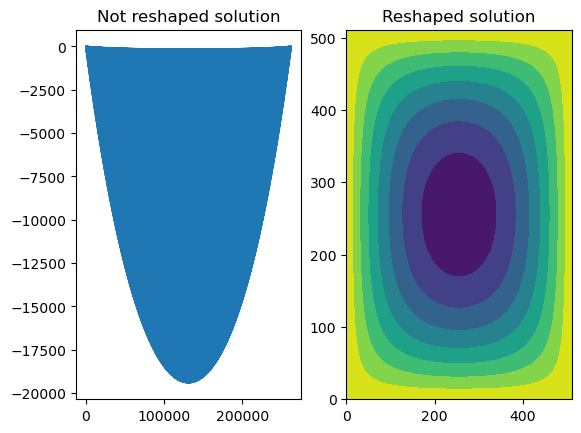

In [18]:
import matplotlib.pyplot as plt
n = 512
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
#A = csr_matrix(A)
rhs = np.ones(n * n)
sol = sp.sparse.linalg.spsolve(A, rhs)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sol)
ax1.set_title('Not reshaped solution')
ax2.contourf(sol.reshape((n, n), order='f'))
ax2.set_title('Reshaped solution')

## Основные выводы

- О параллельном умножении матрицы на вектор и различных способах блочного разделения.
- Формат CSR для хранения
- Проблемы кэширования и параллельной обработки в работе с разреженными матрицами
- Переупорядочение и блочное разделение как способы решения этих проблем

# Questions?

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()